In [1]:
# # 下載資料
# !gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# # 解壓縮
# !unzip data.zip

In [2]:
import os
# 讀取 label.csv
import pandas as pd
# 讀取圖片
from PIL import Image
import numpy as np

import torch
# Loss function
import torch.nn.functional as F
# 讀取資料
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
# 載入預訓練的模型
import torchvision.models as models
# 將資料轉換成符合預訓練模型的形式
import torchvision.transforms as transforms
# 顯示圖片
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", "cuda" if torch.cuda.is_available() else "cpu")

using cuda


In [3]:
# 實作一個繼承 torch.utils.data.Dataset 的 Class 來讀取圖片
class Adverdataset(Dataset):
    def __init__(self, root, label, transforms):
        # 圖片所在的資料夾
        self.root = root
        # 由 main function 傳入的 label
        self.label = torch.from_numpy(label).long()
        # 由 Attacker 傳入的 transforms 將輸入的圖片轉換成符合預訓練模型的形式
        self.transforms = transforms
        # 圖片檔案名稱的 list
        self.fnames = []

        for i in range(200):
            self.fnames.append("{:03d}".format(i))

    def __getitem__(self, idx):
        # 利用路徑讀取圖片
        img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
        # 將輸入的圖片轉換成符合預訓練模型的形式
        img = self.transforms(img)
        # 圖片相對應的 label
        label = self.label[idx]
        return img, label
    
    def __len__(self):
        # 由於已知這次的資料總共有 200 張圖片 所以回傳 200
        return 200

In [4]:
class Classfier:
    def __init__(self, img_dir, label):
        # 讀入預訓練模型 vgg16
        self.model = models.densenet121(pretrained=True)
        self.model.to(DEVICE)
        self.model.eval()
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # 把圖片 normalize 到 0~1 之間 mean 0 variance 1
        self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
        transform = transforms.Compose([
            transforms.Resize((224, 224), interpolation=3),
            transforms.ToTensor(),
            self.normalize
        ])
        # 利用 Adverdataset 這個 class 讀取資料
        self.dataset = Adverdataset(img_dir, label, transform)
        
        self.loader = torch.utils.data.DataLoader(
            self.dataset,
            batch_size = 1,
            shuffle = False,
#             num_workers = 8
        )
    
    def predict(self):
        # 存下一些成功攻擊後的圖片 以便之後顯示
        results = []
        for (data, target) in self.loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = self.model(data)
            results.append(output.clone().detach().cpu().numpy())
        return results

In [5]:
# 讀入圖片相對應的 label
df = pd.read_csv("../data/labels.csv")
df = df.loc[:, 'TrueLabel'].to_numpy()
label_name = pd.read_csv("../data/categories.csv")
label_name = label_name.loc[:, 'CategoryName'].to_numpy()
# new 一個 Attacker class
orig_classifier = Classfier('../data/images', df)
adv_classifier = Classfier('../results/0.02', df)

orig = orig_classifier.predict()
adv = adv_classifier.predict()

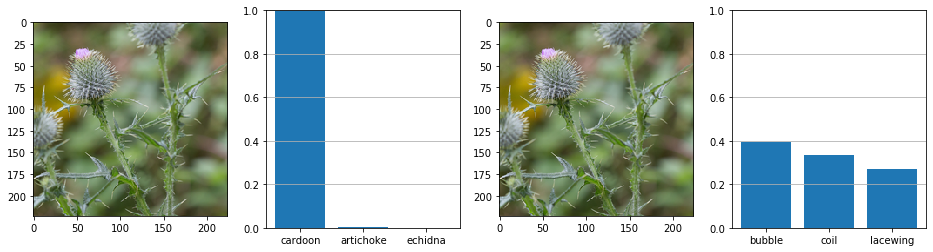

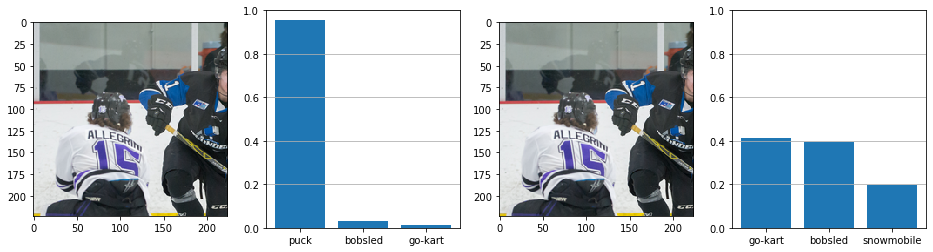

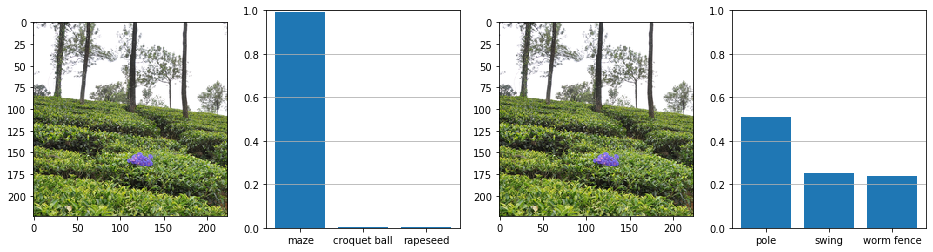

In [6]:
%matplotlib inline
for i in range(123,126):
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    
    orig_prob = orig[i][0]
    orig_idx = np.argsort(orig_prob)[::-1][:3]
    orig_ln = [label_name[_].split(',')[0] for _ in orig_idx]
    orig_pb = np.sort(orig_prob)[::-1][:3]
    # softmax
    orig_pb = np.exp(orig_pb) / np.sum(np.exp(orig_pb))
    
    img = mpimg.imread('../data/images/%03d.png'%i)
    imgplot = ax[0].imshow(img)
    ax[1].set_ylim((0, 1))
    ax[1].grid(b=True, axis='y')
    ax[1].bar(orig_ln, orig_pb)
    
    
    adv_prob = adv[i][0]
    adv_idx = np.argsort(adv_prob)[::-1][:3]
    adv_ln = [label_name[_].split(',')[0] for _ in adv_idx]
    adv_pb = np.sort(adv_prob)[::-1][:3]
    # softmax
    adv_pb = np.exp(adv_pb) / np.sum(np.exp(adv_pb))
    
    img = mpimg.imread('../data/images/%03d.png'%i)
    imgplot = ax[2].imshow(img)
    ax[3].set_ylim((0, 1))
    ax[3].grid(b=True, axis='y')
    ax[3].bar(adv_ln, adv_pb)
    
    plt.show()

In [7]:
torch.cuda.empty_cache()